In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.utils as utils
import matplotlib.animation as animation
from IPython.display import HTML
import time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:',device)
#as provided in ppt. base model
LEARNING_RATE = 5e-5
BATCH_SIZE = 64
# Spatial size of training images. All images will be resized to this size using a transformer
IMAGE_SIZE = 64
# Number of channels in the training images. For color images this is 3
CHANNELS_IMG = 3  
# Size of z latent vector (i.e. size of generator input)
NOISE_DIM = 100
NUM_EPOCHS = 15
# Size of feature maps in discriminator
FEATURES_DISC = 64 
# Size of feature maps in generator
FEATURES_GEN = 64 

weight_clip = 0.01
criticItr = 7

Device: cuda


In [3]:
dataset = datasets.CIFAR10(root='./data/cifar10', download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=128,
                                         shuffle=True, num_workers=2)

Files already downloaded and verified


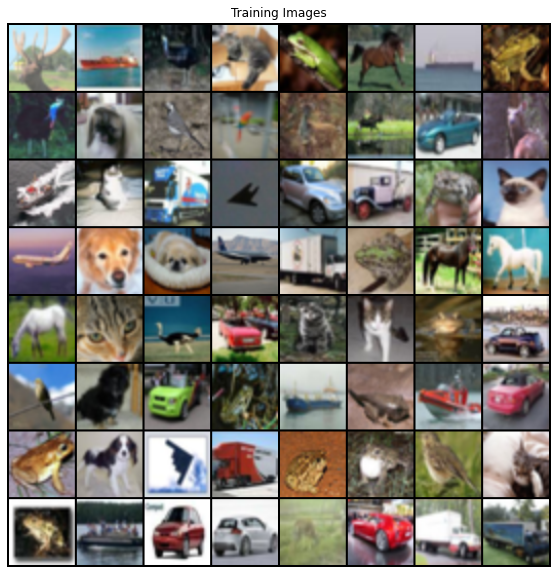

In [4]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [5]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self.Dnet(features_d, features_d * 2, 4, 2, 1),      #out=128,k=5,s=2,p=1
            self.Dnet(features_d * 2, features_d * 4, 4, 2, 1),  #out=256,k=5,s=2,p=1
            self.Dnet(features_d * 4, features_d * 8, 4, 2, 1),  #out=512,k=5,s=2,p=1
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def Dnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine =True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

In [6]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            #Gnet(in_channels, out_channels, kernel_size, stride, padding)
            self.Gnet(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self.Gnet(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self.Gnet(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self.Gnet(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def Gnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels,momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

In [7]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [8]:
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

In [9]:
optimGenerator = optim.RMSprop(gen.parameters(), lr=LEARNING_RATE)
optimDiscriminator = optim.RMSprop(disc.parameters(), lr=LEARNING_RATE)

In [10]:
fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
step = 0

In [11]:
gen.train() , disc.train()

(Generator(
   (net): Sequential(
     (0): Sequential(
       (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
       (1): BatchNorm2d(1024, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (1): Sequential(
       (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (2): Sequential(
       (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (3): Sequential(
       (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (4): C

In [ ]:
GenLoss = []
DiscLoss = []
DiscLossP = []
img_list = []
iters = 0

print("!!Training Started!!")
# start timing
time_start = time.time() 
for epoch in range(NUM_EPOCHS):
    epoch = epoch+1
    
    for batch_idx, data in enumerate(dataloader,0):
        #training with real batch
        real = data[0].to(device)
        batch = real.shape[0]
        # print(batch == BATCH_SIZE)

        # Train Critic(Discriminator): max E[critic(real)] - E[critic(fake)]
        for i in range (criticItr):
          noise = torch.randn(batch, NOISE_DIM, 1, 1).to(device)
          fake = gen(noise) #genrator img data
          critic_real = disc(real).reshape(-1)
          critic_fake = disc(fake).reshape(-1)
          loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
          disc.zero_grad()
          loss_critic.backward(retain_graph=True)
          optimDiscriminator.step()

          # clip critic weights between -0.01, 0.01
          for param in disc.parameters():
              param.data.clamp_(-weight_clip, weight_clip)


        ### Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        output = disc(fake).reshape(-1)
        loss_gen = -torch.mean(output) 
        gen.zero_grad()
        loss_gen.backward()
        optimGenerator.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss Discriminator: {loss_critic:.3f}, loss Generator: {loss_gen:.3f}"
            )
        #saving the losses for every 100 batch
        GenLoss.append(loss_gen.detach().cpu())
        DiscLoss.append(loss_critic.detach().cpu())
        DiscLossP.append(-(loss_critic.detach().cpu()))
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == NUM_EPOCHS) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
        
time_end = time.time()
print('elapsed time：%.2f s.'%(time_end-time_start))

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator Loss During Training")
plt.plot(GenLoss,label="Gen")
# plt.plot(DiscLossP,label="Disc")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Discriminator Loss During Training")
# plt.plot(GenLoss,label="Gen")
plt.plot(DiscLossP,label="Disc")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
np.max(GenLoss),np.min(GenLoss) ,np.max(DiscLossP), np.min(DiscLossP)

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:

real_batch = next(iter(dataloader))


plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))


plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()
fig.savefig('WGAN_BEST_FAKE_32.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')